In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [128]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

from sklearn.metrics import mean_squared_error
from math import sqrt

In [129]:
df = pd.read_csv("C:/Users/hp/Downloads/monthly_milk_production.csv",index_col='Date',parse_dates=True)
df.index.freq='MS'

In [130]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

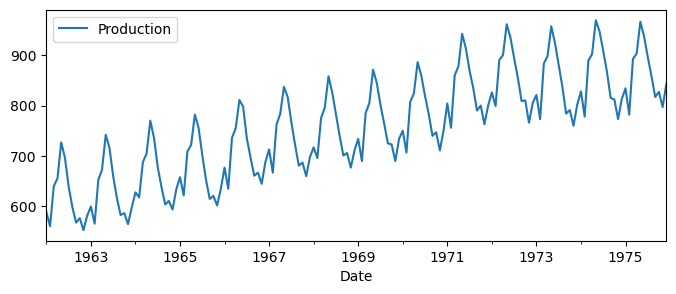

In [131]:
df.plot(figsize=(8,3))

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose

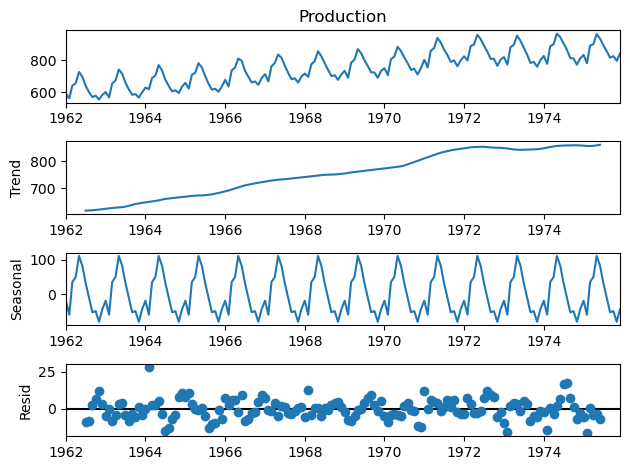

In [133]:
results = seasonal_decompose(df['Production'])
results.plot();

In [134]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [158]:
train = df.iloc[:156]
test = df.iloc[156:]

In [159]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [160]:
from keras.preprocessing.sequence import TimeseriesGenerator

# About TimeseriesGenerator

In [161]:
#Timeseriesgenerator
#This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride,
#length of history, etc., to produce batches for training/validation.

#data	Indexable generator (such as list or Numpy array) containing consecutive data points (timesteps).
#       The data should be at 2D, and axis 0 is expected to be the time dimension.
#targets	Targets corresponding to timesteps in data. It should have same length as data.

In [162]:
# In the context of time series forecasting using a TimeseriesGenerator, having the same data for both data and targets arguments
# is common and makes sense. This is because the generator is designed to create sequences from the time series data for training
# models where the objective is to predict future values based on past observations.

# Here's a breakdown of why the data and targets are often the same:

# Data (Features) and Targets (Labels):

# data: This is the input time series data from which the generator will create sequences.
# targets: This is the same time series data, but it is used as the target values that the model will try to predict.

----*-------------*--------------*----------------*--------------*----------------*-----------------*-----------------*-----

In [163]:
n_features=1
n_input=12

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 12, 100)           40800     
                                                                 
 dropout_18 (Dropout)        (None, 12, 100)           0         
                                                                 
 lstm_27 (LSTM)              (None, 12, 50)            30200     
                                                                 
 dropout_19 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_28 (LSTM)              (None, 10)                2440      
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 1)               

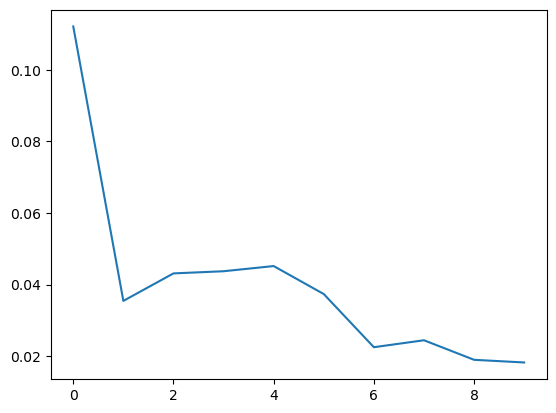

In [164]:
def generating(n_input, n_features, scaled_train):
    
    # generator fxn
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    X,y = generator[0]
    
    # build model
    model = Sequential()

    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
    model.add(Dropout(0.2))  # Adding Dropout for regularization


    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))  # Adding Dropout for regularization


    model.add(LSTM(10, activation='relu'))
    model.add(Dropout(0.2))  # Adding Dropout for regularization

    # Add a Dense layer
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    
    # fit model 
    model.fit(generator,epochs=10)
    
    # define loss
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    
    return model
    
model= generating(n_input, n_features, scaled_train)


In [165]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 12, 100)           40800     
                                                                 
 dropout_18 (Dropout)        (None, 12, 100)           0         
                                                                 
 lstm_27 (LSTM)              (None, 12, 50)            30200     
                                                                 
 dropout_19 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_28 (LSTM)              (None, 10)                2440      
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 1)               

1/1 [==============================] - 0s 47ms/step
RSME EQUALS TO 31.975436056873413


C:\Users\hp\AppData\Local\Temp\ipykernel_3084\1671032469.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


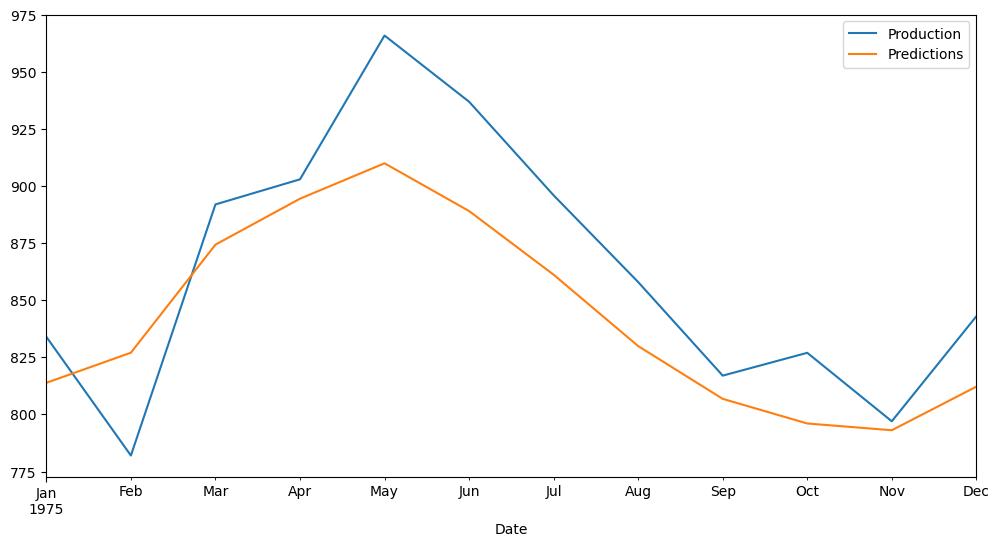

In [166]:
def predict_future_values(model, scaled_train, n_input, n_features,test):
    test_predictions = []
    
    # Prepare the first evaluation batch from the end of the training data
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):
        # Get the prediction value for the current batch
        current_pred = model.predict(current_batch)[0]        
        # Append the prediction to the list of predictions
        test_predictions.append(current_pred)        
        # Update the batch to include the new prediction and remove the first value
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
        
    # inverse conversions  
    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = true_predictions
    test.plot(figsize=(12,6))
    
    #error
    rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
    print( "RSME EQUALS TO" ,rmse)

    return test_predictions

test_predictions= predict_future_values(model, scaled_train, n_input, n_features,test)